# Simple Moving Average Backtest

Firstly, lets import all of the dependencies we need:

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import math

## Variable Setup

In the following set the variables up you would like to run the SMA backtest for (dates are of the format 'yyyy-mm-dd' and the window size is in days):

In [3]:
ticker_symbol = 'TSLA'
start_date = '2020-01-01'
end_date = '2020-11-30'
sma_window_size = 50

## Get the Stock Price Data

Get the data as defined by the previous and visualise:

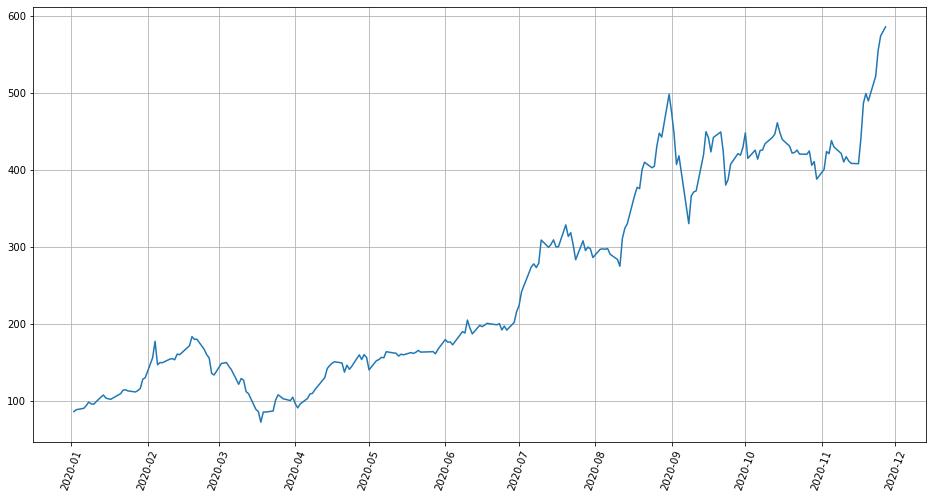

In [4]:
stock_price_data = yf.Ticker(ticker_symbol)
hist = stock_price_data.history(start=start_date, end=end_date)

plt.figure(figsize=(16,8)) 
plt.plot(hist.index, hist['Close'])
plt.xticks(rotation=70)
plt.grid()
plt.show()

## Calculate the Simple Moving Average Data

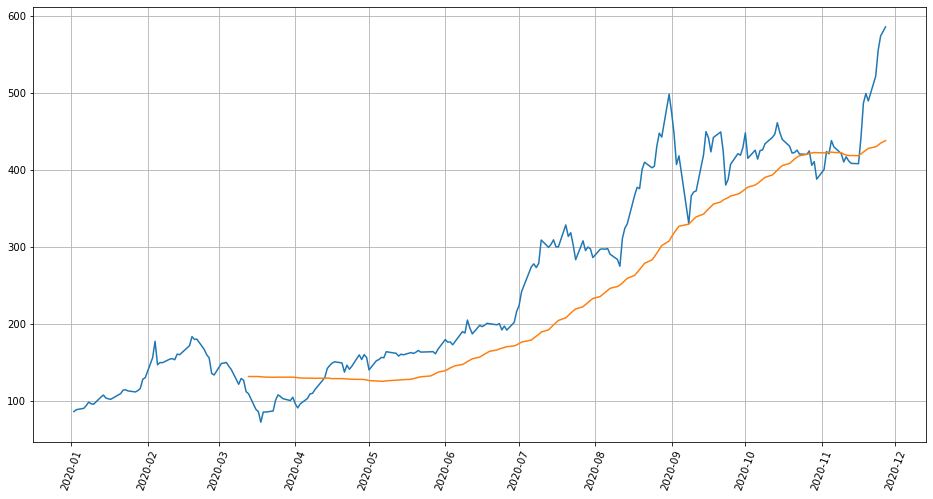

In [5]:
hist['SMA'] = hist['Close'].rolling(sma_window_size).mean()

plt.figure(figsize=(16,8)) 
plt.plot(hist.index, hist['Close'])
plt.plot(hist.index, hist['SMA'])
plt.xticks(rotation=70)
plt.grid()
plt.show()

## Backtest

In [6]:
backtest = pd.DataFrame(columns=['BuyDate', 'BuyPrice', 'SellDate', 'SellPrice',\
    'SellBuyDiff', 'SellBuyPercentageDiff', 'CumulativeSellBuyDiff', 'SellFirstBuyPercentageDiff'])

currently_holding = False

counter = 0

buy_date = None
buy_price = None
sell_date = None
sell_price = None

first_buy_price = None

for i, row in hist.iterrows():
    if not currently_holding and not math.isnan(row['SMA']) and row['Close'] > row['SMA']:
        buy_date = i
        buy_price = row['Close']
        currently_holding = True
        
        if first_buy_price == None:
            first_buy_price = buy_price
    if currently_holding and not math.isnan(row['SMA']) and row['Close'] < row['SMA']:
        sell_date = i
        sell_price = row['Close']
        
        backtest.at[i, 'BuyDate'] = buy_date
        backtest.at[i, 'BuyPrice'] = buy_price
        backtest.at[i, 'SellDate'] = sell_date
        backtest.at[i, 'SellPrice'] = sell_price
        backtest.at[i, 'SellBuyDiff'] = sell_price - buy_price
        backtest.at[i, 'SellBuyPercentageDiff'] = ((backtest.at[i, 'SellBuyDiff']) / buy_price) * 100
        backtest.at[i, 'CumulativeSellBuyDiff'] = backtest['SellBuyDiff'].sum()
        backtest.at[i, 'SellFirstBuyPercentageDiff'] = ((sell_price - first_buy_price) / first_buy_price) * 100
        
        currently_holding = False
        counter += 1
          
print(backtest)

                        BuyDate BuyPrice             SellDate SellPrice  \
2020-10-28  2020-04-13 00:00:00   130.19  2020-10-28 00:00:00    406.02   
2020-11-04  2020-11-03 00:00:00    423.9  2020-11-04 00:00:00    420.98   
2020-11-09  2020-11-05 00:00:00   438.09  2020-11-09 00:00:00    421.26   

           SellBuyDiff SellBuyPercentageDiff CumulativeSellBuyDiff  \
2020-10-28      275.83               211.867                275.83   
2020-11-04    -2.91998             -0.688838                272.91   
2020-11-09      -16.83              -3.84167                256.08   

           SellFirstBuyPercentageDiff  
2020-10-28                    211.867  
2020-11-04                    223.358  
2020-11-09                    223.573  


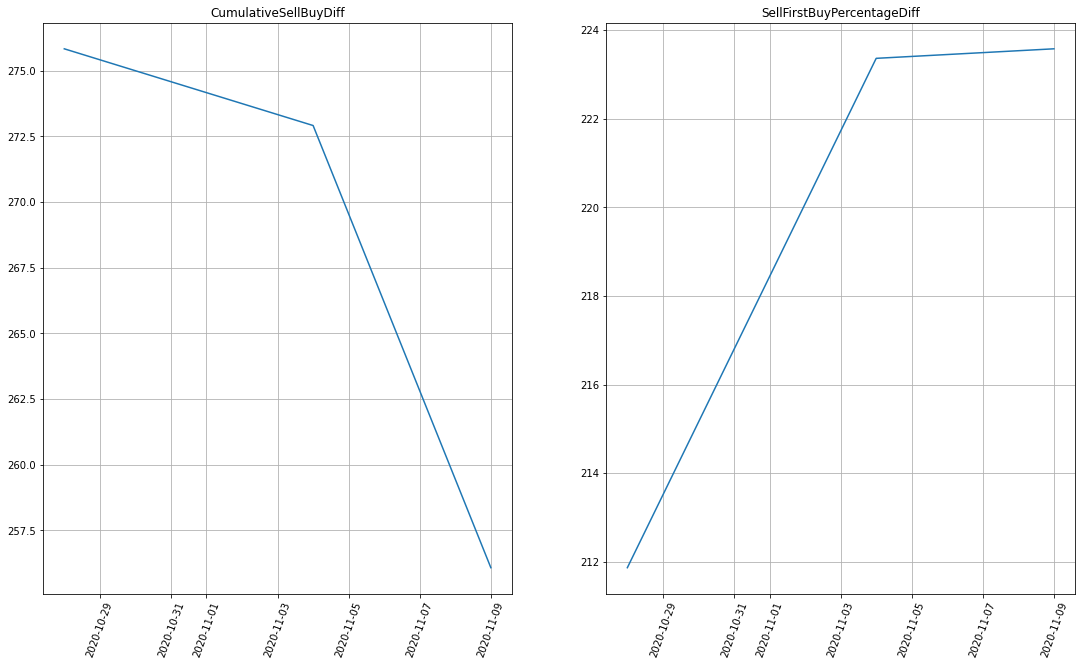

In [7]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.subplot(1, 2, 1)
plt.title('CumulativeSellBuyDiff')
plt.plot(backtest['SellDate'], backtest['CumulativeSellBuyDiff'])
plt.xticks(rotation=70)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('SellFirstBuyPercentageDiff')
plt.plot(backtest['SellDate'], backtest['SellFirstBuyPercentageDiff'])
plt.xticks(rotation=70)
plt.grid()

plt.show()

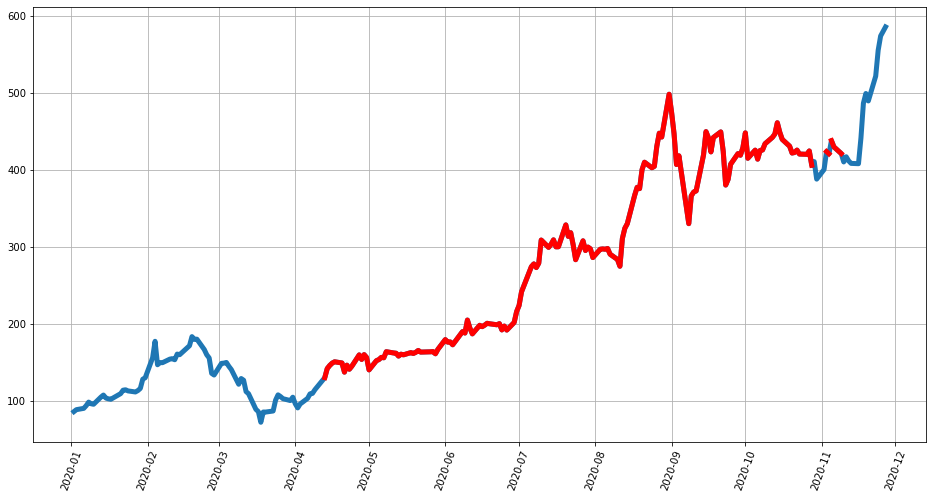

In [19]:
plt.figure(figsize=(16,8)) 
plt.plot(hist.index, hist['Close'])

for i, row in backtest.iterrows():
    hist_slice = hist.loc[hist.index >= row['BuyDate']]
    hist_slice = hist_slice.loc[hist_slice.index <= row['SellDate']]
    plt.plot(hist_slice.index, hist_slice['Close'], 'r', linewidth=3)

plt.xticks(rotation=70)
plt.grid()
plt.show()